In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import pandas as pd
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import cv2
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import os
from skimage import measure
import math
import shutil
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Background

## A little about melanoma

Meloma is an aggrresive skin cancer that starts in cells that produce melanin (skin pigement). However, it is relatively common for people to develop benign (not cancer) lesions on their skin. One of the challenges in diagnosing melamona is accurately identfying whether a specifc lesion is cancer (malignant) or not (benign).


Here are some examples of benign lesions:

![ISIC_0080752.jpg](./BadImages/ISIC_0080752.jpg)
![ISIC_0078703.jpg](./GoodImages/ISIC_0078703.jpg)
![ISIC_0079038.jpg](./BadImages/ISIC_0079038.jpg)
![ISIC_0077472.jpg](./BadImages/ISIC_0077472.jpg)
![ISIC_0076995.jpg](./GoodImages/ISIC_0076995.jpg)
![ISIC_0075663.jpg](./BadImages/ISIC_0075663.jpg)
![ISIC_0052212.jpg](./GoodImages/ISIC_0052212.jpg)
![ISIC_0074542.jpg](./BadImages/ISIC_0074542.jpg)
![ISIC_0015719.jpg](./BadImages/ISIC_0015719.jpg)


And here are some examples of malignant lesions:
![ISIC_0274382.jpg](./GoodImages/ISIC_0274382.jpg)
![ISIC_0273046.jpg](./GoodImages/ISIC_0273046.jpg)
![ISIC_0207268.jpg](./GoodImages/ISIC_0207268.jpg)
![ISIC_0149568.jpg](./BadImages/ISIC_0149568.jpg)

## What are some similarities within benign lesions? Malignant lesions?

## Data

The data for this workshop comes from the SIIM ISIC 2020 challenge. https://challenge2020.isic-archive.com/

It contains 33,126 images of both benign and maligant lesions.

Of the 33,126 lesions, only 584 are maligant (~1.76%)

I have divided the data into "Good" and "Bad" images based on image quality.

# What exactly are images?

Before we are able to apply machine learning to images, we need to know how they are represented. 

Let's start with grayscale images first. A grayscale image is represented by a 2-D grid of pixels. Each pixel has a number associated with it, that determines how bright the image is. Notice that the values range from 0 to 255.

![Grayscale](./Figures/Number8.png)

Colour images are a little more complex. Typically, a colour image is represented by 3 2-D grids of pixels, referred to as colour channels. These are RGB, or red, blue, green.

![Colour](./Figures/rgb.jpg)


## Visualizing a Benign Lesion

Now let's talk a closer look at our images. Run the cell below to visualize the individual channels of a benign skin lesion image

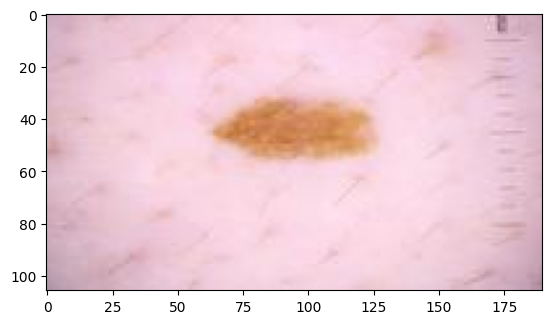

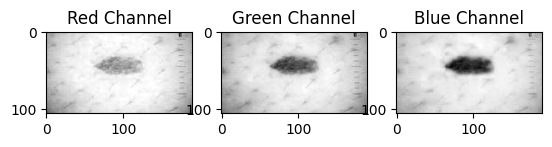

In [2]:
# Read the image
img = imageio.imread('./GoodImages/ISIC_0078703.jpg')

#Show the image
plt.imshow(img)

# Split the image into its color channels
red_channel = img[:, :, 0]
green_channel = img[:, :, 1]
blue_channel = img[:, :, 2]

# Plot each channel separately
fig, axs = plt.subplots(1, 3)
axs[0].imshow(red_channel, cmap='gray')
axs[0].set_title('Red Channel')
axs[1].imshow(green_channel, cmap='gray')
axs[1].set_title('Green Channel')
axs[2].imshow(blue_channel, cmap='gray')
axs[2].set_title('Blue Channel')

plt.show()

## Visualizing a Malignant Lesion

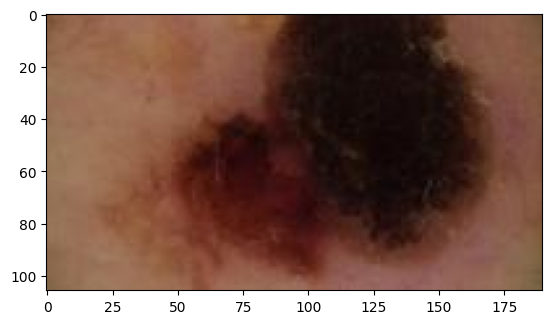

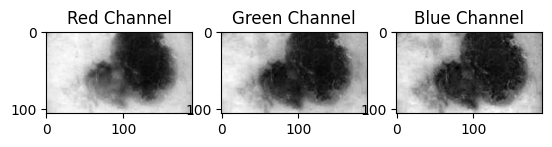

In [3]:
# Read the image
img = imageio.imread('GoodImages/ISIC_0369831.jpg')

#Show the image
plt.imshow(img)

# Split the image into its color channels
red_channel = img[:, :, 0]
green_channel = img[:, :, 1]
blue_channel = img[:, :, 2]

# Plot each channel separately
fig, axs = plt.subplots(1, 3)
axs[0].imshow(red_channel, cmap='gray')
axs[0].set_title('Red Channel')
axs[1].imshow(green_channel, cmap='gray')
axs[1].set_title('Green Channel')
axs[2].imshow(blue_channel, cmap='gray')
axs[2].set_title('Blue Channel')

plt.show()

# Labels

The last thing we need before we're ready to start machine learning is the label associated with each image. The organization who released the dataset also release the labels. 

The last column "target" tells us whether a given image is benign (0) or maligant (1).

Run the cell below to load the labels.

In [4]:
df = pd.read_csv("train.csv")
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


# The ABCDEs of Melanoma

When assessing a skin lesion, doctors are on the lookout for red flags that are likely signs of melamona. These are sometimes known as the ABCDEs. https://www.skincancer.org/skin-cancer-information/melanoma/melanoma-warning-signs-and-images/#:~:text=Any%20change%20in%20size%2C%20shape,a%20warning%20sign%20of%20melanoma.

A for Asymmetry
![a](./Figures/A.png)

B for Border 
![b](./Figures/B.png)

C for Colour 
![c](./Figures/C.png)

D for Diameter 
![d](./Figures/D.png)

E for Evolving 
![e](./Figures/E.png)

# Let's build a simple model!

Based on our observations of the malignant and benign images, as well as the ABCDEs that we just talked about, let's try to build a model that classifies darker lesions as malignant, and lighter lesions as benign. Looking at the different colour channels, it looks like the brown lesions are darkest on the blue channel, so let's stick to that for now.

First, let's define a function that calculates the ratio of dark pixels to light pixels, based on a threshold value.

Remember that pixel values range from 0 to 255, and the darker the lesion is, the lower that value (since increases in pixel value corresponds to increased brightness).

## Defining our dark to light ratio function

In [5]:
# We have to pass the image path and thershold value to our function.

def getDarktoLightRatio(img_path, threshold):
    img = np.array(imageio.imread(img_path)[:, :, 2])
  
    count = np.sum(img > threshold)
    ratio = count / img.size
    return ratio


getDarktoLightRatio('GoodImages/ISIC_0082348.jpg', 100)

0.9637040714995034

In [6]:
THRESHOLD = 100
print(getDarktoLightRatio('GoodImages/ISIC_0096227.jpg', THRESHOLD))
print(getDarktoLightRatio('GoodImages/ISIC_0078703.jpg', THRESHOLD))

0.9984607745779543
0.9703078450844091


## Using our function to classify images

In [7]:
folder_path = ('GoodImages')
images = os.listdir(folder_path)
NUMBER_TO_CLASSIFY = 1000
predictions = [None] * NUMBER_TO_CLASSIFY
reals = [None] * NUMBER_TO_CLASSIFY
THRESHOLD = 100


for i, filename in enumerate(tqdm(images[:NUMBER_TO_CLASSIFY])):
    img_path = os.path.join(folder_path, filename)
    pred = getDarktoLightRatio(img_path, THRESHOLD)
    truth = df[df["image_name"] == filename[:-4]]["target"].values[0]
    
    predictions[i] = pred < 0.5
    reals[i] = truth

print("\n")
print(f'Number of real benign images: {NUMBER_TO_CLASSIFY - np.sum(reals)} and Number of real malignant images: {np.sum(reals)}')
print(f'Number of predicted benign images: {NUMBER_TO_CLASSIFY - np.sum(predictions)} and Number of predicted malignant images: {np.sum(predictions)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 547.92it/s]



Number of real benign images: 985 and Number of real malignant images: 15
Number of predicted benign images: 885 and Number of predicted malignant images: 115


# How should we evaluate our model?

Let's run our model again, and this time report the accuracy, defined by the percent of correct classifactions. Below, we define our function for calculating accuracy.

In [8]:
def accuracy(predictions, ground_truths):
    correct_predictions = np.sum(predictions == ground_truths)
    total_predictions = predictions.size
    accuracy = correct_predictions / total_predictions
    return accuracy

And now let's use it

In [9]:
folder_path = ('GoodImages')
images = os.listdir(folder_path)
NUMBER_TO_CLASSIFY = 1000
predictions = [None] * NUMBER_TO_CLASSIFY
reals = [None] * NUMBER_TO_CLASSIFY
THRESHOLD = 100


for i, filename in enumerate(tqdm(images[:NUMBER_TO_CLASSIFY])):
    img_path = os.path.join(folder_path, filename)
    pred = getDarktoLightRatio(img_path, THRESHOLD)
    truth = df[df["image_name"] == filename[:-4]]["target"].values[0]
    
    predictions[i] = pred < 0.5
    reals[i] = truth

print("\n")
print(f'Accuracy is: {accuracy(np.array(predictions), np.array(reals))}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 564.33it/s]



Accuracy is: 0.876


## Try and get 98% accuracy

Accuracy seems like a natural choice by which to evaluate how a model is performing. And it looks like we are doing well! Our accuracy is probably somewhere between 80% to 90%. 

There is a very simple way to alter our model so it has 98% accuracy. Try to do it below.

HINT: Remember that only about 2% of images are malignant.
HINT: change the THRESHOLD value

In [10]:
folder_path = ('GoodImages')
images = os.listdir(folder_path)
NUMBER_TO_CLASSIFY = 1000
predictions = [None] * NUMBER_TO_CLASSIFY
reals = [None] * NUMBER_TO_CLASSIFY
THRESHOLD = None #Hint: change this value.


for i, filename in enumerate(tqdm(images[:NUMBER_TO_CLASSIFY])):
    img_path = os.path.join(folder_path, filename)
    pred = getDarktoLightRatio(img_path, THRESHOLD)
    truth = df[df["image_name"] == filename[:-4]]["target"].values[0]
    
    predictions[i] = pred < 0.5
    reals[i] = truth

print("\n")
print(f'Accuracy is: {accuracy(np.array(predictions), np.array(reals))}')

  0%|                                                                                                                                                                                                             | 0/1000 [00:00<?, ?it/s]


TypeError: '>' not supported between instances of 'int' and 'NoneType'

98% accuracy is a great score on a test. But is it a good score for a cancer detection comptuer model?

## Confusion matrix and AUC

Two other (and better than accuracy) ways of evaluating your model are the confusion matrix, and the area under the receiver characteristic operating curve. Let's go over the confusion matrix first.

This is what a confusion matrix looks like. It tells you your true positves and true negatives, as well as your false positives and false negatives.
![confusionmatrix](./Figures/confusionmatrix.png)

Let's calculate the confusion matrix for our ratio function with a threshold of 100. 

We'll just print out the true positives, true negatives, false positives and false negatives.

In [11]:
folder_path = ('GoodImages')
images = os.listdir(folder_path)
NUMBER_TO_CLASSIFY = 1000
predictions = [None] * NUMBER_TO_CLASSIFY
reals = [None] * NUMBER_TO_CLASSIFY
THRESHOLD = 100


for i, filename in enumerate(tqdm(images[:NUMBER_TO_CLASSIFY])):
    img_path = os.path.join(folder_path, filename)
    pred = getDarktoLightRatio(img_path, THRESHOLD)
    truth = df[df["image_name"] == filename[:-4]]["target"].values[0]
    
    predictions[i] = pred < 0.5
    reals[i] = truth

tn, fp, fn, tp = confusion_matrix(reals, predictions).ravel()

print("\n")
print(f'True positive is: {tp}')
print(f'True negative is: {tn}')
print(f'False positive is: {fp}')
print(f'False negative is: {fn}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 554.94it/s]



True positive is: 3
True negative is: 873
False positive is: 112
False negative is: 12


Remember, our accuracy is around 80% to 90%, but out of 1000 samples, have have approximately 100 false positives and 19 false negatives. If you were a patient, would you be happy with these results?

Can you predict what these rates will be when we set our threshold to 0? (Thereby obtaining 98% accuracy).

In [12]:
folder_path = ('GoodImages')
images = os.listdir(folder_path)
NUMBER_TO_CLASSIFY = 1000
predictions = [None] * NUMBER_TO_CLASSIFY
reals = [None] * NUMBER_TO_CLASSIFY
THRESHOLD = 0


for i, filename in enumerate(tqdm(images[:NUMBER_TO_CLASSIFY])):
    img_path = os.path.join(folder_path, filename)
    pred = getDarktoLightRatio(img_path, THRESHOLD)
    truth = df[df["image_name"] == filename[:-4]]["target"].values[0]
    
    predictions[i] = pred < 0.5
    reals[i] = truth

tn, fp, fn, tp = confusion_matrix(reals, predictions).ravel()

print("\n")
print(f'True positive is: {tp}')
print(f'True negative is: {tn}')
print(f'False positive is: {fp}')
print(f'False negative is: {fn}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 525.76it/s]



True positive is: 0
True negative is: 985
False positive is: 0
False negative is: 15


## The AUC

While the confusion matrix contains useful information, it also consists of 4 values. Normally, when we want to compare models, it is useful to have one value that summarizes their performance. This is where the AUC comes in.

For the purposes of today's workshop, consider AUCs close to 1 to be good, and AUCs close to 0.5 to be bad.

Let's rerun our analysis, but this time using the AUC.

And with THRESHOLD = 0

In [13]:
folder_path = ('GoodImages')
images = os.listdir(folder_path)
NUMBER_TO_CLASSIFY = 1000
predictions = [None] * NUMBER_TO_CLASSIFY
reals = [None] * NUMBER_TO_CLASSIFY
THRESHOLD = 0


for i, filename in enumerate(tqdm(images[:NUMBER_TO_CLASSIFY])):
    img_path = os.path.join(folder_path, filename)
    pred = getDarktoLightRatio(img_path, THRESHOLD)
    truth = df[df["image_name"] == filename[:-4]]["target"].values[0]
    
    predictions[i] = pred < 0.5
    reals[i] = truth

tn, fp, fn, tp = confusion_matrix(reals, predictions).ravel()

auc = metrics.roc_auc_score(reals, predictions)
print("\n")
print(f'AUC is: {auc}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 555.24it/s]



AUC is: 0.5


Even though the model is more accurate when THRESHOLD = 0, it's AUC is not better.

# Machine learning

Although what we did previously could be considered AI, it is not machine learning. The key characteristic of machine learning is that it "learns" from data. Essentially, this means that the machine learning model fits its internal parameters based on the data.

For example, if we wanted to convert our simple light and dark ratio function to a machine learning model, we simply need to fit our function parameters on the data.

What are the parameters? In our case, it is the value of THRESHOLD.

## Using Logistic Regression

Here, we will use a model called logistic regression to learn from our data and perform machine learning. 

First, we need to create a datafile that the model can use.

In [14]:
folder_path = ('GoodImages')
images = os.listdir(folder_path)
thresholds = [25, 50, 75, 100, 125, 150, 175, 200]
data = []
truths = []
NUMBER_TO_CLASSIFY = 3000 # Let's do this for 3000 images

for i, filename in enumerate(tqdm(images[:NUMBER_TO_CLASSIFY])):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = imageio.imread(os.path.join(folder_path, filename))[:, :, 2]
        truth = df[df["image_name"] == filename[:-4]]["target"].values[0]
        truths.append(truth)
        ratios = []
        for threshold in thresholds:
            above_threshold = np.sum(image > threshold)
            ratio = above_threshold / image.size
            ratios.append(ratio)
        data.append(ratios)

df_dataColour = pd.DataFrame(data, columns=[f'threshold_{t}' for t in thresholds])
df_dataColour["truth"] = truths

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 475.17it/s]


Now we can use the linear regression model. Python makes this easy! Since we're going to resuse this classification model, let's turn this into a function that we can reuse.

In [15]:
def runClasificationModel(df):
    # Define the features and target variable
    X = df.drop('truth', axis=1)
    y = df['truth']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Scale the features using only the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the logistic regression model on the training data
    clf = LogisticRegression(class_weight='balanced', solver='liblinear')
    clf.fit(X_train_scaled, y_train)


    # make predictions on the train set
    y_pred = clf.predict(X_train_scaled)
    auc = metrics.roc_auc_score(y_train, y_pred)
    print("\n")
    print("Training Set Results")
    print(f'AUC is: {auc}')

    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

    print(f'True positive is: {tp}')
    print(f'True negative is: {tn}')
    print(f'False positive is: {fp}')
    print(f'False negative is: {fn}')

    # make predictions on the test set
    y_pred = clf.predict(X_test_scaled)
    auc = metrics.roc_auc_score(y_test, y_pred)
    print("\n")
    print("Testing Set Results")
    print(f'AUC is: {auc}')

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f'True positive is: {tp}')
    print(f'True negative is: {tn}')
    print(f'False positive is: {fp}')
    print(f'False negative is: {fn}')

Now let's apply this model to the datafile that we just created.

In [16]:
runClasificationModel(df_dataColour)



Training Set Results
AUC is: 0.5826015803422039
True positive is: 18
True negative is: 1502
False positive is: 711
False negative is: 19


Testing Set Results
AUC is: 0.5554701019034801
True positive is: 3
True negative is: 507
False positive is: 236
False negative is: 4


## Including shape features

Up to now, we've only used colour properties to classify images. However, we saw in the ABCDEs that shape features are important as well. In the cells below, we will calculate some shape features.

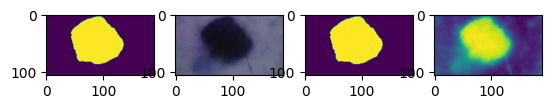

In [17]:
def circularity(region):
    area = region.area
    perimeter = region.perimeter

    if perimeter == 0:
        return 0
    else:
        return (4 * math.pi * area) / (perimeter ** 2)


def getLesion(image, plot=False):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.bitwise_not(img)

    blurred_image = cv2.GaussianBlur(img, (7,7), 0)

    ret, thresh1 = cv2.threshold(blurred_image, 200, 255, cv2.THRESH_BINARY + 
                                      cv2.THRESH_OTSU) 

    label_img = measure.label(thresh1)
    # Extract properties of labeled regions
    regions = measure.regionprops_table(label_img, properties=['label', 'area', 'perimeter', 
                                                             'eccentricity',
                                                             'extent',
                                                             'moments_hu'])

    max_area = 600
    max_label = None
    best_perim = 0
    best_ecc = 0
    best_extent = 0
    best_mhu_trans = 0
    best_mhu_scale = 0
    best_mhu_rot = 0
    for region in measure.regionprops(label_img):
        if circularity(region) > 0.5:
            if region.area > max_area:
                max_area = region.area
                max_label = region.label
                best_perim = region.perimeter
                best_ecc = region.eccentricity
                best_extent = region.extent
                best_mhu_trans = region.moments_hu[0]
                best_mhu_scale = region.moments_hu[1]
                best_mhu_rot = region.moments_hu[2]

    mask_of_island = (label_img == max_label).astype(int)

    if plot:
      #plt.imshow(thresh1)
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

        # Display your images on each of the axes
        ax1.imshow(mask_of_island)
        ax2.imshow(image)
        ax3.imshow(thresh1)
        ax4.imshow(blurred_image)

        # Show the plot
        plt.show()
    return [max_area, best_perim, best_ecc,
          best_extent, best_mhu_trans, best_mhu_scale, best_mhu_rot], mask_of_island


image = cv2.imread('GoodImages/ISIC_0624498.jpg')
_ = getLesion(image, True)

Now let's use these functions to to create a datafile that includes shape features. This will take a little longer.

In [ ]:
#First order stats
folder_path = ('GoodImages')
images = os.listdir(folder_path)
data = []
truths = []
NUMBER_TO_CLASSIFY = 3000 # Let's do this for 3,0000 images

for i, filename in enumerate(tqdm(images[:NUMBER_TO_CLASSIFY])):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = cv2.imread(os.path.join(folder_path, filename))
        truth = df[df["image_name"] == filename[:-4]]["target"].values[0]
        truths.append(truth)
        b, g, r = cv2.split(image)
        
        props, mask = getLesion(image)
        stats = props
        #for channel in b, g, r:
        for j in range(3):
            mask = cv2.convertScaleAbs(mask)
            masked_c = cv2.bitwise_and(image[:,:,j], image[:,:,j], mask=mask)

            c_mean = cv2.mean(image[:,:,j], mask)[0]
            c_std = np.std(masked_c[mask>0])
            c_median = np.median(masked_c[mask>0])

            c_skew = skew(masked_c[mask>0])
            c_kurtosis = kurtosis(masked_c[mask>0])
            stats.append(c_mean)
            stats.append(c_std)
            stats.append(c_median)
            stats.append(c_skew)
            stats.append(c_kurtosis)
        data.append(stats)
  
df_data = pd.DataFrame(data)
df_data["truth"] = truths

  2%|██▉                                                                                                                                                                                                | 45/3000 [00:00<00:21, 137.67it/s]

In [ ]:
df_data.head()

In [ ]:
df_dataColour.head()

And let's run our classification model!

In [ ]:
runClasificationModel(df_data)

# Comparing results

We saw that using our handcrafted algorithm, our AUC was **0.5** (worst performance). When using a machine learning logistic regression model, our testing AUC increased to **0.58.** When including shape features, our test AUC increased to **0.74.**

In the Kaggle competition, the top performing model had an AUC of **0.95!**
https://www.kaggle.com/competitions/siim-isic-melanoma-classification/leaderboard

# Some final thoughts

## "Bad" Images

Keep in mind, that our model performances were only achieved on the subset of images that were "good". Now, let's take a look at some of the "bad" images. Can you identify what properties about these images might make them hard to classify?

In [ ]:
folder_path = 'BadImages'
image_extensions = ['.jpg', '.jpeg', '.png']

images = [file for file in os.listdir(folder_path) if any(file.endswith(ext) for ext in image_extensions)]

fig, axs = plt.subplots(50, 1, figsize=(100,250))
axs = axs.flatten()
for i in range(min(50, len(images))):
    image_path = os.path.join(folder_path, images[i])
    image = Image.open(image_path)
    axs[i].imshow(image)
    axs[i].axis('off')
plt.show()

## Ethical considerations

We just saw 50 images. What is one quality that all of these images have in common?

Although meloma is more prevalent in White people compared to people of colour, everyone can develop melanoma during their lifetimes.

In fact, melanoma is more deadly for the Black population becaused it is diagnosed later. https://www.aamc.org/news-insights/why-are-so-many-black-patients-dying-skin-cancer

Why might this be?

With this in mind, how does this affect how you would train, evaluate, and implement a melanoma detection model?